<a href="https://colab.research.google.com/github/schokoro/cnn_crf_nertagger/blob/master/NER_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN и CRF для извлечения именованных сущностей



In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    

Tesla T4


In [0]:
import sys
sys.path.append('/content/cnn_crf_nertagger')

In [0]:
!rm -rf cnn_crf_nertagger/

In [0]:
!git clone -b master https://github.com/schokoro/cnn_crf_nertagger.git > /dev/null
!pip install allennlp wget youtokentome> /dev/null


Cloning into 'cnn_crf_nertagger'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 154 (delta 70), reused 124 (delta 48), pack-reused 0
Receiving objects: 100% (154/154), 43.67 KiB | 532.00 KiB/s, done.
Resolving deltas: 100% (70/70), done.


In [0]:
%load_ext autoreload
%autoreload 2

import spacy
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
import numpy as np
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from allennlp.data.dataset_readers.conll2003 import Conll2003DatasetReader
from allennlp.common.util import ensure_list
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from pdb import set_trace
from gc import collect
from tqdm.notebook import tqdm
import wget
import cnn_crf_nertagger
from cnn_crf_nertagger.modules.modules import NERTaggerModel, NERTagger
from cnn_crf_nertagger.utils.pipeline import train_eval_loop, predict_with_model
from cnn_crf_nertagger.utils.prepare import tag_corpus_to_tensor, tokenize_corpus, make_yttm_tokenizer
from os import path, listdir
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
sns.set()
%matplotlib inline

rcParams['figure.figsize'] = 12, 12
# torch.backends.cudnn.deterministic=False 

## Подготовка данных




### Загружаем корпуса

In [0]:
!rm -fv /content/cnn_crf_nertagger/data/*


removed '/content/cnn_crf_nertagger/data/readme.txt'


In [0]:
path_data = '/content/cnn_crf_nertagger/data/'
path_train = '/content/cnn_crf_nertagger/data/eng.train'
path_valid = '/content/cnn_crf_nertagger/data/eng.testa'
path_test = '/content/cnn_crf_nertagger/data/eng.testb'

dataset_urls = {
    'eng.testa': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa',
    'eng.testb': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb',
    'eng.train': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train'}
for file_name in dataset_urls:
    wget.download(dataset_urls[file_name], path.join(path_data, file_name))

In [0]:
%%time
conll_reader = Conll2003DatasetReader()
train_conll = ensure_list(conll_reader.read(path_train))
valid_conll = ensure_list(conll_reader.read(path_valid))
test_conll = ensure_list(conll_reader.read(path_test))

14041it [00:01, 13022.50it/s]
3250it [00:00, 9462.97it/s]
3453it [00:00, 25533.95it/s]

CPU times: user 1.5 s, sys: 63.8 ms, total: 1.56 s
Wall time: 1.56 s


In [0]:
all_conll = train_conll + valid_conll + test_conll
len(all_conll), len(train_conll), len(valid_conll), len(test_conll)

(20744, 14041, 3250, 3453)

### Готовим словари соответсвия тег-id и bpe - токенизатор



In [0]:
tags = set()
tokens = set()

max_sent_len = 0
for instance in all_conll[: ]:
    if len(instance['tokens']) >  max_sent_len:
        max_sent_len = len(instance['tokens'])
    tags.update(instance['tags'])
    tokens.update(instance['tokens'])
    
print(f'Максимальная длина предложения: {max_sent_len} токенов')

Максимальная длина предложения: 124 токенов


In [0]:
%time bpe_tokenizer = make_yttm_tokenizer(train_conll, 400)

CPU times: user 143 ms, sys: 31.4 ms, total: 175 ms
Wall time: 130 ms


In [0]:
%%time
max_token_len = 0
for p in tqdm(range(101)):
    len_tokens = [len(bpe_tokenizer.encode(token.text, dropout_prob=p/100))  for token in tokens]
    if max(len_tokens) > max_token_len:
        p_dropout = .01 * p
        max_token_len = max(len_tokens)

print(f'Максимальная длина токена: {max_token_len} субтокенов при вероятности дропаута {p_dropout}')


Максимальная длина токена: 62 субтокенов при вероятности дропаута 0.12
CPU times: user 9.02 s, sys: 49.1 ms, total: 9.07 s
Wall time: 9.1 s


In [0]:
tag2id = {tag: num for num, tag in enumerate(['<NOTAG>'] + list(tags))}
# char2id = {char: num+1 for num, char in enumerate(chars)}
# id2char = {item[1]: item[0] for item in char2id.items()}

В датасете присутствует очень мало тегов вида B-XXX. Попробуем чуть размножить предложения с этими тегами. Использование дропаута в bpe внесёт немного разнообразия в эти предложения.

In [0]:
%%time
BPE_DROPOUT = .1
train_inputs, train_targets = tag_corpus_to_tensor(train_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, 20, dropout=BPE_DROPOUT)
valid_inputs, valid_targets = tag_corpus_to_tensor(valid_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, dropout=BPE_DROPOUT)
test_inputs, test_targets = tag_corpus_to_tensor(test_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, dropout=BPE_DROPOUT)

100%|██████████| 3453/3453 [00:01<00:00, 2376.36it/s]

CPU times: user 9.59 s, sys: 771 ms, total: 10.4 s
Wall time: 10.4 s


In [0]:
train_dataset = TensorDataset(train_inputs, train_targets)
valid_dataset = TensorDataset(valid_inputs, valid_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

## Создаём и обучаем сеть

In [0]:
models_path = '/content/cnn_crf_nertagger/models/best_model.pth'

In [0]:
try:
    del model    
    collect()
except:
    print('no model')
finally:
    torch.cuda.empty_cache()


no model


Сеть состоит из двух однотипных свёрточных блоков и CRF. На первом уровне мы осуществляем свёртку над субтокенами и делаем глобал-пуллинг. Затем получившиеся эмбедденги токенов передаём на следующий свёрточный блок. Он значительно глубже, чтобы увеличить рецептивное поле. Выход второго блока передаём в CRF, который возвращает нам `log-likelihood`.

In [0]:
torch.cuda.empty_cache()
model = NERTaggerModel(len(bpe_tokenizer.vocab()), len(tag2id), tag2id, embedding_size=64,
                                              single_backbone_kwargs=dict(layers_n=2, kernel_size=3, dropout=0.3, dilation=None),
                                              context_backbone_kwargs=dict(layers_n=5, kernel_size=3, dropout=0.3, dilation=[1, 1, 2 , 2, 1]))
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 112869


In [0]:
# try:
#     model.load_state_dict(torch.load(models_path))
# except:
#     print('no model')

In [0]:
(best_val_loss,
 best_model,
 losses) = train_eval_loop(model,
                               train_dataset,
                               valid_dataset,
                               lr=1.25e-3,
                               epoch_n=200,
                               batch_size=128,
                               device=device,
                               early_stopping_patience=8,
                               l2_reg_alpha = 1e-6,
                               max_batches_per_epoch_train=100,
                               max_batches_per_epoch_val=100,
                               lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                                                                     optim, patience=3,
                                                                                     factor=0.2,
                                                                                     threshold=1e-3,
                                                                                     verbose=True),
                               verbose_batch=False)
 
torch.save(best_model.state_dict(), models_path)

Эпоха 0
Эпоха: 101 итераций, 22.87 сек
Среднее значение функции потерь на обучении 9.416808524934373
Среднее значение функции потерь на валидации 4.7430995519344625
Новая лучшая модель!

Эпоха 1
Эпоха: 101 итераций, 22.89 сек
Среднее значение функции потерь на обучении 4.201901331986531
Среднее значение функции потерь на валидации 3.4011924404364366
Новая лучшая модель!

Эпоха 2
Эпоха: 101 итераций, 22.84 сек
Среднее значение функции потерь на обучении 3.1742055770194177
Среднее значение функции потерь на валидации 2.7983909203455997
Новая лучшая модель!

Эпоха 3
Эпоха: 101 итераций, 23.09 сек
Среднее значение функции потерь на обучении 2.682133466890543
Среднее значение функции потерь на валидации 2.4445137542027693
Новая лучшая модель!

Эпоха 4
Эпоха: 101 итераций, 23.61 сек
Среднее значение функции потерь на обучении 2.3278534034691236
Среднее значение функции потерь на валидации 2.2063632974257836
Новая лучшая модель!

Эпоха 5
Эпоха: 101 итераций, 23.88 сек
Среднее значение функции

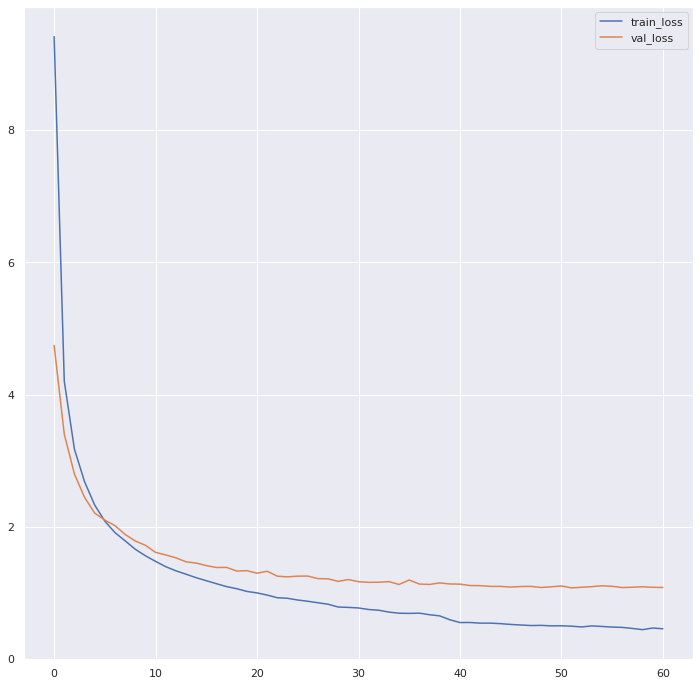

In [0]:
pd.DataFrame(losses).plot();

In [0]:
model.load_state_dict(torch.load(models_path))

<All keys matched successfully>

## Проверки

In [0]:
id2tag = {item[1]: item[0] for item in tag2id.items()}
UNIQUE_TAGS = [id2tag[i] for i in range(len(tag2id))]


### Проверка - train

In [0]:
train_pred = predict_with_model(model, train_dataset)
print(classification_report(train_targets.view(-1), train_pred.reshape(-1), target_names=UNIQUE_TAGS))

472it [00:17, 27.56it/s]                               


              precision    recall  f1-score   support

     <NOTAG>       1.00      1.00      1.00   1646703
       I-LOC       0.94      0.98      0.96      9166
       I-PER       0.98      0.99      0.99     11588
       I-ORG       0.94      0.96      0.95     10721
       B-LOC       1.00      0.09      0.17       231
      B-MISC       0.97      0.68      0.80       777
       B-ORG       1.00      0.50      0.67       504
           O       1.00      1.00      1.00    184278
      I-MISC       0.93      0.97      0.95      6076

    accuracy                           1.00   1870044
   macro avg       0.97      0.80      0.83   1870044
weighted avg       1.00      1.00      1.00   1870044



### Проверка - valid

In [0]:
# valid_pred = predict_with_model(model, valid_dataset)


# print(classification_report(valid_targets.view(-1), valid_pred.reshape(-1), target_names=UNIQUE_TAGS))

### Проверка - test

In [0]:
test_pred = predict_with_model(model, test_dataset)

print(classification_report(test_targets.view(-1), test_pred.reshape(-1), target_names=UNIQUE_TAGS))

100%|██████████| 108/107.90625 [00:03<00:00, 27.72it/s]


              precision    recall  f1-score   support

     <NOTAG>       1.00      1.00      1.00    381737
       I-LOC       0.78      0.86      0.82      1919
       I-PER       0.88      0.89      0.88      2773
       I-ORG       0.76      0.77      0.77      2491
       B-LOC       0.00      0.00      0.00         6
      B-MISC       0.33      0.11      0.17         9
       B-ORG       0.00      0.00      0.00         5
           O       0.99      0.98      0.99     38323
      I-MISC       0.71      0.76      0.74       909

    accuracy                           1.00    428172
   macro avg       0.61      0.60      0.60    428172
weighted avg       1.00      1.00      1.00    428172



## Применение теггера

In [0]:
!python -m spacy download en_core_web_sm > /dev/null

In [0]:

ner_tagger = NERTagger(model, bpe_tokenizer, UNIQUE_TAGS, max_sent_len, max_token_len, BPE_DROPOUT)

In [0]:
nlp = spacy.load('en_core_web_sm')


In [0]:
test_sentences = [
    'Mr Trump said Mr Linick no longer had his full confidence and that he would be removed in 30 days.',
    'Mr Linick had begun investigating Secretary of State Mike Pompeo for suspected abuse of office, reports say.',
    'Democrats say Mr Trump is retaliating against public servants who want to hold his administration to account.',
    'Donald Trump, who is campaigning for re-election in November, has stepped up his attacks on China in recent weeks, blaming it for the spread of Covid-19.',
    'The team led by Fernando Novas from the Natural Sciences Museum in Buenos Aires discovered many fossils during its month-long field work in Estancia La Anita, in southern Santa Cruz province.',
    "The rehearsal at Kennedy Space Center saw a Falcon-9 vehicle's ascent into the sky deliberately terminated just 80 seconds after lift-off."
]
test_sentences_tokenized = tokenize_corpus(test_sentences)
# test_sentences_tokenized = [[token.text for token in nlp.tokenizer(sent) ] for sent in test_sentences]

In [0]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, ner_tagger(test_sentences)):
    print()
    assert len(sent_tokens) == len(sent_tags)
    print(' '.join('{}-{}'.format(tok, tag) for tok, tag in zip(sent_tokens, sent_tags)))

1it [00:00, 73.92it/s]                    


Mr-I-PER Trump-I-PER said-O Mr-O Linick-I-PER no-O longer-O had-O his-O full-O confidence-O and-O that-O he-O would-O be-O removed-O in-O 30-O days-O .-O

Mr-I-PER Linick-I-PER had-O begun-O investigating-O Secretary-O of-O State-O Mike-I-PER Pompeo-O for-O suspected-O abuse-O of-O office-O ,-O reports-O say-O .-O

Democrats-I-MISC say-O Mr-O Trump-I-LOC is-O retaliating-O against-O public-O servants-O who-O want-O to-O hold-O his-O administration-O to-O account-O .-O

Donald-I-PER Trump-I-PER ,-O who-O is-O campaigning-O for-O re-O --O election-O in-O November-O ,-O has-O stepped-O up-O his-O attacks-O on-O China-I-LOC in-O recent-O weeks-O ,-O blaming-O it-O for-O the-O spread-O of-O Covid-19-O .-O

The-O team-O led-O by-O Fernando-I-PER Novas-I-PER from-O the-O Natural-I-ORG Sciences-I-ORG Museum-I-ORG in-O Buenos-I-LOC Aires-I-LOC discovered-O many-O fossils-O during-O its-O month-O --O long-O field-O work-O in-O Estancia-I-LOC La-I-LOC Anita-I-LOC ,-O in-O southern-O Santa-I-LOC 